INFO:root:Epoch 1/20 Loss: 1.5352
INFO:root:Epoch 11/20 Loss: 1.2529


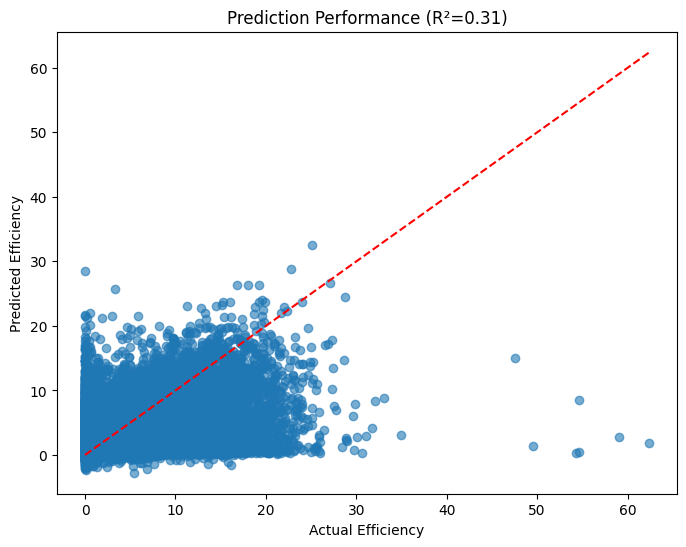

INFO:root:Final Metrics - MSE: 11.33, R²: 0.31, Pearson: 0.59


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
from scipy.stats import pearsonr

# Configure logging
logging.basicConfig(level=logging.INFO)

class HybridEditor(nn.Module):
    """Hybrid CNN + feature-based model for editing prediction"""
    def __init__(self, seq_length=74, num_features=9):
        super().__init__()
        
        # CNN for sequence pattern detection
        self.seq_conv = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(10)
        )
        
        # Feature processing
        self.feature_net = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
        # Combined processing
        self.combined = nn.Sequential(
            nn.Linear(64 * 10 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.1),  # Reduced dropout
            nn.Linear(128, 1)
        )

    def forward(self, seq, features):
        seq = seq.permute(0, 2, 1)  # [batch, channels, length]
        seq_out = self.seq_conv(seq)
        seq_out = seq_out.view(seq_out.size(0), -1)
        
        feat_out = self.feature_net(features)
        
        combined = torch.cat([seq_out, feat_out], dim=1)
        return self.combined(combined)

def one_hot_encode(seq):
    """Convert DNA sequence to one-hot encoding"""
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 
               'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1],
               'x': [0, 0, 0, 0]}
    return np.array([mapping.get(c, [0, 0, 0, 0]) for c in seq])

def prepare_data(df):
    """Convert dataframe to tensors with feature scaling"""
    seqs = [one_hot_encode(s) for s in df['WT74_On']]
    seq_tensor = torch.tensor(seqs, dtype=torch.float32)

    feature_cols = ['PBSlen', 'RTlen', 'Edit_len', 'Tm1', 'Tm2', 
                    'nGCcnt1', 'fGCcont1', 'MFE1', 'DeepSpCas9_score']
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[feature_cols])

    feature_tensor = torch.tensor(scaled_features, dtype=torch.float32)
    labels = torch.tensor(df['Measured_PE_efficiency'].values, dtype=torch.float32).unsqueeze(1)
    
    return seq_tensor, feature_tensor, labels

def train(model, X_seq, X_feat, y, epochs=100, batch_size=32):
    """Training loop"""
    dataset = torch.utils.data.TensorDataset(X_seq, X_feat, y)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Reduce LR over time
    criterion = nn.HuberLoss(delta=1.0)  # More robust to outliers
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for seq, feat, labels in loader:
            optimizer.zero_grad()
            outputs = model(seq, feat)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        scheduler.step()  # Adjust learning rate
        
        if epoch % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs} Loss: {total_loss/len(loader):.4f}')

def evaluate(model, X_seq, X_feat, y):
    """Model evaluation"""
    with torch.no_grad():
        preds = model(X_seq, X_feat).squeeze().numpy()
    actual = y.squeeze().numpy()
    
    mse = mean_squared_error(actual, preds)
    r2 = r2_score(actual, preds)
    pearson = pearsonr(actual, preds)[0]
    
    plt.figure(figsize=(8,6))
    plt.scatter(actual, preds, alpha=0.6)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'r--')
    plt.title(f'Prediction Performance (R²={r2:.2f})')
    plt.xlabel('Actual Efficiency')
    plt.ylabel('Predicted Efficiency')
    plt.show()
    
    return {'mse': mse, 'r2': r2, 'pearson': pearson}

def main():
    # Load and prepare data
    df = pd.read_csv('DT.csv')
    seq_tensor, feat_tensor, labels = prepare_data(df)
    
    # Split data
    X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = \
        train_test_split(seq_tensor, feat_tensor, labels, test_size=0.2)
    
    # Initialize model
    model = HybridEditor(seq_length=74, num_features=9)
    
    # TrainAC
    train(model, X_seq_train, X_feat_train, y_train, epochs=20)
    
    # Evaluate
    results = evaluate(model, X_seq_test, X_feat_test, y_test)
    logging.info(f"Final Metrics - MSE: {results['mse']:.2f}, R²: {results['r2']:.2f}, Pearson: {results['pearson']:.2f}")

if __name__ == "__main__":
    main()


Epoch 1/10 | Loss: 12.6146
Epoch 2/10 | Loss: 11.3749
Epoch 3/10 | Loss: 10.6401
Epoch 4/10 | Loss: 9.7915
Epoch 5/10 | Loss: 8.9479
Epoch 6/10 | Loss: 8.2911
Epoch 7/10 | Loss: 7.7267
Epoch 8/10 | Loss: 7.3021
Epoch 9/10 | Loss: 6.9564
Epoch 10/10 | Loss: 6.6537
Test MSE: 9.5637
Test R²: 0.4046
Test Pearson Correlation: 0.6442


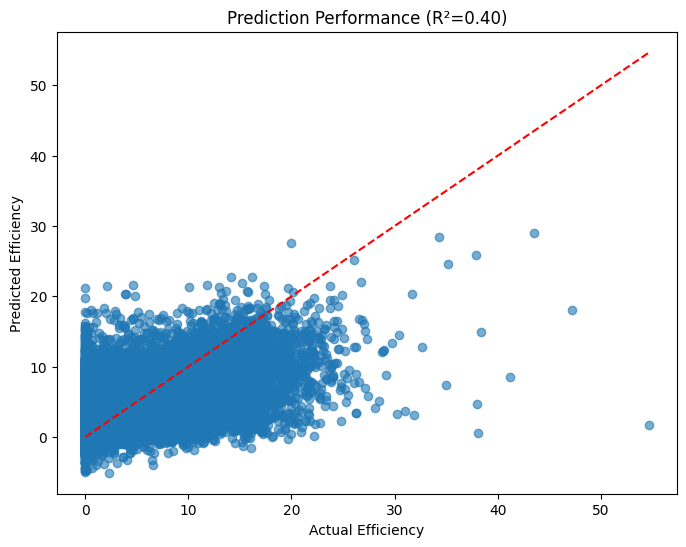

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# --------------------------
# Model Definition
# --------------------------
class DNAHybridModel(nn.Module):
    def __init__(self, seq_length=74, num_features=5):
        super().__init__()
        self.seq_net = nn.Sequential(
            nn.Conv1d(5, 32, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(4),
            nn.Conv1d(32, 64, kernel_size=5),
            nn.AdaptiveMaxPool1d(16)
        )
        self.feat_net = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.head = nn.Sequential(
            nn.Linear(64*16 + 32, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )
        self._initialize_weights()

    def forward(self, x_seq, x_feat):
        x_seq = x_seq.permute(0, 2, 1)  # [batch, channels, seq_len]
        seq_out = self.seq_net(x_seq).flatten(1)
        feat_out = self.feat_net(x_feat)
        return self.head(torch.cat([seq_out, feat_out], dim=1))

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# --------------------------
# Dataset Definition
# --------------------------
class DNADataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self.nt_map = {'A':0, 'T':1, 'G':2, 'C':3, 'x':4}
        
        feature_cols = ['PBSlen', 'RTlen', 'Edit_len', 'Tm1', 'nGCcnt1']
        self.scaler = StandardScaler()
        self.df[feature_cols] = self.scaler.fit_transform(self.df[feature_cols])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq = np.zeros((74, 5), dtype=np.float32)
        for i, c in enumerate(row['WT74_On'][:74]):
            seq[i, self.nt_map.get(c,4)] = 1
        features = row[['PBSlen','RTlen','Edit_len','Tm1','nGCcnt1']].values.astype(np.float32)
        target = np.array(row['Measured_PE_efficiency'], dtype=np.float32)
        return seq, features, target

# --------------------------
# Training Function
# --------------------------
def train(model, train_loader, optimizer, criterion, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for seqs, feats, labels in train_loader:
            seqs, feats, labels = seqs.to(device), feats.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(seqs, feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f}")

# --------------------------
# Evaluation Function
# --------------------------
def evaluate(model, test_loader, device):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for seqs, feats, labels in test_loader:
            seqs, feats = seqs.to(device), feats.to(device)
            outputs = model(seqs, feats).cpu().numpy()
            preds.extend(outputs.flatten())
            actuals.extend(labels.numpy())

    mse = mean_squared_error(actuals, preds)
    r2 = r2_score(actuals, preds)
    pearson = pearsonr(actuals, preds)[0]
    
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R²: {r2:.4f}")
    print(f"Test Pearson Correlation: {pearson:.4f}")

    # Scatter Plot
    plt.figure(figsize=(8,6))
    plt.scatter(actuals, preds, alpha=0.6)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
    plt.xlabel('Actual Efficiency')
    plt.ylabel('Predicted Efficiency')
    plt.title(f'Prediction Performance (R²={r2:.2f})')
    plt.show()

# --------------------------
# Main Execution
# --------------------------
if __name__ == "__main__":
    class Args:
        data_path = "DT.csv"
        batch_size = 256
        epochs = 10
        lr = 1e-3
        test_split = 0.2

    args = Args()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load dataset and split into train/test
    dataset = DNADataset(args.data_path)
    train_size = int((1 - args.test_split) * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    # Initialize model, optimizer, and loss function
    model = DNAHybridModel().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    criterion = nn.MSELoss()

    # Train and Evaluate
    train(model, train_loader, optimizer, criterion, device, args.epochs)
    evaluate(model, test_loader, device)


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------
# LSTM Hybrid Model
# --------------------------
class LSTMHybridModel(nn.Module):
    def __init__(self, seq_length=74, num_features=5, hidden_dim=64, lstm_layers=2):
        super().__init__()
        
        # LSTM for sequence processing
        self.lstm = nn.LSTM(input_size=5, hidden_size=hidden_dim, 
                            num_layers=lstm_layers, batch_first=True, 
                            bidirectional=True)
        
        # Feature processing
        self.feat_net = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
        # Combined processing
        self.head = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x_seq, x_feat):
        lstm_out, _ = self.lstm(x_seq)
        lstm_out = lstm_out[:, -1, :]  # Take last output from LSTM
        feat_out = self.feat_net(x_feat)
        combined = torch.cat([lstm_out, feat_out], dim=1)
        return self.head(combined)

# --------------------------
# Dataset Definition
# --------------------------
class DNADataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self.nt_map = {'A': 0, 'T': 1, 'G': 2, 'C': 3, 'x': 4}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # One-hot encode sequence
        seq = np.zeros((74, 5), dtype=np.float32)
        for i, c in enumerate(row['WT74_On'][:74]):
            seq[i, self.nt_map.get(c, 4)] = 1
        
        # Features and target
        features = row[['PBSlen', 'RTlen', 'Edit_len', 'Tm1', 'nGCcnt1']].values.astype(np.float32)
        target = np.array(row['Measured_PE_efficiency'], dtype=np.float32)
        
        return seq, features, target

# --------------------------
# Training & Evaluation
# --------------------------
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for seqs, feats, labels in train_loader:
            seqs, feats, labels = seqs.to(device), feats.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(seqs, feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f}")
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = sum(criterion(model(seqs.to(device), feats.to(device)), labels.to(device).unsqueeze(1)).item()
                           for seqs, feats, labels in val_loader) / len(val_loader)
            print(f"Validation Loss: {val_loss:.4f}")

def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    actuals, predictions = [], []
    with torch.no_grad():
        for seqs, feats, labels in test_loader:
            seqs, feats = seqs.to(device), feats.to(device)
            preds = model(seqs, feats).cpu().numpy().flatten()
            actuals.extend(labels.numpy())
            predictions.extend(preds)
    
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    print(f"Test MSE: {mse:.4f}, R²: {r2:.4f}")

# --------------------------
# Main Execution
# --------------------------
if __name__ == "__main__":
    # Load dataset
    dataset = DNADataset("DT.csv")
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
    
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=128)
    test_loader = DataLoader(test_set, batch_size=128)
    
    # Initialize model
    model = LSTMHybridModel()
    
    # Train model
    train_model(model, train_loader, val_loader, epochs=20, lr=1e-3)
    
    # Evaluate model
    evaluate_model(model, test_loader)


Epoch 1/20 | Loss: 13.3540
Validation Loss: 12.7620
Epoch 2/20 | Loss: 13.0082
Validation Loss: 12.5952
Epoch 3/20 | Loss: 12.9738
Validation Loss: 12.4905
Epoch 4/20 | Loss: 12.9182
Validation Loss: 12.5374
Epoch 5/20 | Loss: 12.9005
Validation Loss: 12.5425
Epoch 6/20 | Loss: 12.8759
Validation Loss: 12.5569
Epoch 7/20 | Loss: 12.8633
Validation Loss: 12.5445
Epoch 8/20 | Loss: 12.8731
Validation Loss: 12.6345
Epoch 9/20 | Loss: 12.8467
Validation Loss: 12.6720
Epoch 10/20 | Loss: 12.8325
Validation Loss: 12.5150
Epoch 11/20 | Loss: 12.8272
Validation Loss: 12.4343
Epoch 12/20 | Loss: 12.7299
Validation Loss: 12.3349
Epoch 13/20 | Loss: 12.6785
Validation Loss: 12.2651
Epoch 14/20 | Loss: 12.7324
Validation Loss: 12.4767
Epoch 15/20 | Loss: 12.8027
Validation Loss: 12.3228
Epoch 16/20 | Loss: 12.4960
Validation Loss: 11.9962
Epoch 17/20 | Loss: 12.2785
Validation Loss: 11.8244
Epoch 18/20 | Loss: 11.9667
Validation Loss: 11.4777
Epoch 19/20 | Loss: 11.7527
Validation Loss: 11.2762
Ep

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

###############################
# PART 1: CLASSICAL ML MODELS #
###############################

# --- Feature Engineering for Classical Models ---
def calculate_sequence_features(sequence):
    """Compute hand-engineered features from a DNA sequence."""
    features = {}
    # GC Content
    gc_content = (sequence.count('G') + sequence.count('C')) / len(sequence)
    features['gc_content'] = gc_content
    features['gc_window_10'] = (sequence[10:20].count('G') + sequence[10:20].count('C')) / 10
    # Simple thermodynamic feature: polyT runs
    features['polyT_runs'] = sum(1 for i in range(len(sequence)-3) if sequence[i:i+4]=='TTTT')
    # Simple sequence motifs (binary flags)
    features['GG_motif'] = 1 if 'GG' in sequence[20:25] else 0
    features['AAAA_motif'] = 1 if 'AAAA' in sequence[30:40] else 0
    # Positional base counts for selected positions (A and T)
    for pos in [5, 10, 15, 20]:
        features[f'pos{pos}_A'] = 1 if sequence[pos] == 'A' else 0
        features[f'pos{pos}_T'] = 1 if sequence[pos] == 'T' else 0
    return features

def create_biological_features(df):
    """Generate a dataframe of features from sequence and experimental data."""
    seq_features = df['WT74_On'].apply(calculate_sequence_features).apply(pd.Series)
    exp_features = df[['PBSlen', 'RTlen', 'Edit_len', 'Tm1', 'nGCcnt1']]
    return pd.concat([seq_features, exp_features], axis=1)

def run_classical_models():
    # Load data
    df = pd.read_csv('DT.csv')
    X = create_biological_features(df)
    y = df['Measured_PE_efficiency']

    # Split data (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define base models (excluding SVR due to dataset size)
    rf = RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42)
    gb = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, random_state=42)

    # Define stacking ensemble using RF and GB
    base_models = [('rf', rf), ('gb', gb)]
    stacking = StackingRegressor(estimators=base_models,
                                 final_estimator=GradientBoostingRegressor(n_estimators=50, learning_rate=0.1),
                                 cv=5)

    # Fit and evaluate each model
    models = {'RandomForest': rf, 'GradientBoosting': gb, 'Stacking': stacking}
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        results[name] = {'MSE': mse, 'R2': r2}
        print(f"Model: {name} | Test MSE: {mse:.4f}, R²: {r2:.4f}")
    
    return results

##################################
# PART 2: DEEP LEARNING (LSTM)   #
##################################

# --- PyTorch Dataset for Deep Learning Model ---
class DNADataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self.nt_map = {'A': 0, 'T': 1, 'G': 2, 'C': 3, 'x': 4}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # One-hot encode sequence (shape: 74 x 5)
        seq = np.zeros((74, 5), dtype=np.float32)
        for i, c in enumerate(row['WT74_On'][:74]):
            seq[i, self.nt_map.get(c, 4)] = 1
        # Extra features (using the same 5 features as above)
        features = row[['PBSlen', 'RTlen', 'Edit_len', 'Tm1', 'nGCcnt1']].values.astype(np.float32)
        target = np.array(row['Measured_PE_efficiency'], dtype=np.float32)
        return seq, features, target

# --- LSTM-based Hybrid Model ---
class LSTMHybridModel(nn.Module):
    def __init__(self, seq_length=74, num_features=5, hidden_dim=64, lstm_layers=2):
        super().__init__()
        # LSTM for sequence processing (bidirectional)
        self.lstm = nn.LSTM(input_size=5, hidden_size=hidden_dim, 
                            num_layers=lstm_layers, batch_first=True, 
                            bidirectional=True)
        # Feature processing
        self.feat_net = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        # Combined head
        self.head = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        
    def forward(self, x_seq, x_feat):
        lstm_out, _ = self.lstm(x_seq)
        lstm_out = lstm_out[:, -1, :]  # Last time-step output
        feat_out = self.feat_net(x_feat)
        combined = torch.cat([lstm_out, feat_out], dim=1)
        return self.head(combined)

def train_deep_model(model, train_loader, val_loader, epochs=30, lr=1e-3, weight_decay=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for seqs, feats, labels in train_loader:
            seqs = seqs.to(device)
            feats = feats.to(device)
            labels = labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(seqs, feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation loss
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for seqs, feats, labels in val_loader:
                seqs = seqs.to(device)
                feats = feats.to(device)
                labels = labels.to(device).unsqueeze(1)
                outputs = model(seqs, feats)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Plot training and validation loss
    plt.figure(figsize=(8,6))
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Deep Model Training & Validation Loss")
    plt.legend()
    plt.show()

def evaluate_deep_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    actuals, predictions = [], []
    with torch.no_grad():
        for seqs, feats, labels in test_loader:
            seqs = seqs.to(device)
            feats = feats.to(device)
            preds = model(seqs, feats).cpu().numpy().flatten()
            predictions.extend(preds)
            actuals.extend(labels.numpy())
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    print(f"Deep Model Test MSE: {mse:.4f}, R²: {r2:.4f}")
    return mse, r2

def run_deep_learning_model():
    # Load dataset for deep learning (using one-hot encoding)
    dataset = DNADataset("DT.csv")
    # Split dataset (80/10/10 split)
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
    
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=128)
    test_loader = DataLoader(test_set, batch_size=128)
    
    # Initialize model
    model = LSTMHybridModel()
    
    # Train model
    train_deep_model(model, train_loader, val_loader, epochs=30, lr=1e-3, weight_decay=1e-5)
    
    # Evaluate model
    mse, r2 = evaluate_deep_model(model, test_loader)
    return mse, r2

#########################################
# PART 3: Compare All Models' Performance
#########################################
if __name__ == "__main__":
    print("Running Classical ML Models...\n")
    classical_results = run_classical_models()
    
    print("\nRunning Deep Learning Model (LSTM)...\n")
    deep_mse, deep_r2 = run_deep_learning_model()
    
    print("\nSummary of Results:")
    for model_name, metrics in classical_results.items():
        print(f"{model_name}: MSE = {metrics['MSE']:.4f}, R² = {metrics['R2']:.4f}")
    print(f"LSTM Deep Model: MSE = {deep_mse:.4f}, R² = {deep_r2:.4f}")


Running Classical ML Models...

Model: RandomForest | Test MSE: 12.7400, R²: 0.2253
Model: GradientBoosting | Test MSE: 12.3562, R²: 0.2486
Model: Stacking | Test MSE: 12.2964, R²: 0.2523

Running Deep Learning Model (LSTM)...

Epoch 1/30 | Train Loss: 13.3788 | Val Loss: 12.7477


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
from sklearn.metrics import mean_squared_error, r2_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Data Preprocessing Class
class CRISPRDataset(torch.utils.data.Dataset):
    def __init__(self, df, feature_scaler=None, target_scaler=None, train=True, sequence_length=73):
        self.sequence_length = sequence_length
        self.nucleotide_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'x': 4}
        
        # Extract features with safer column indexing and error handling
        try:
            numerical_features = df.iloc[:, 14:33].astype(float).fillna(0).values
            position_features = df[['Edit_pos', 'Edit_len', 'RHA_len', 'PBSlen', 'RTlen', 'RT-PBSlen']].values
            type_features = df[['type_sub', 'type_ins', 'type_del']].values
            # Removed DeepSpCas9_score
        except KeyError as e:
            print(f"Column error: {e}. Please check your column names.")
            raise
        
        # More robust sequence processing
        def encode_sequence(seq):
            # Handle potential issues with sequence length
            seq = str(seq)[:self.sequence_length].ljust(self.sequence_length, 'x')
            encoding = np.zeros((self.sequence_length, 5))
            for i, nucleotide in enumerate(seq):
                encoding[i, self.nucleotide_map.get(nucleotide, 4)] = 1
            return encoding.flatten()
        
        wt_sequences = df['WT74_On'].values
        edited_sequences = df['Edited74_On'].values
        
        # Convert to numpy arrays safely
        try:
            encoded_wt = np.array([encode_sequence(seq) for seq in wt_sequences])
            encoded_edited = np.array([encode_sequence(seq) for seq in edited_sequences])
        except Exception as e:
            print(f"Error encoding sequences: {e}")
            raise
        
        # Debug shapes for feature preprocessing
        if train:
            print(f"Encoded WT shape: {encoded_wt.shape}")
            print(f"Encoded edited shape: {encoded_edited.shape}")
            print(f"Numerical features shape: {numerical_features.shape}")
            print(f"Position features shape: {position_features.shape}")
            print(f"Type features shape: {type_features.shape}")
        
        # Concatenate all features - removed deep_score
        self.X = np.concatenate([encoded_wt, encoded_edited, numerical_features, position_features, type_features], axis=1)
        self.y = df['Measured_PE_efficiency'].values.reshape(-1, 1)
        
        if train:
            print(f"Final X shape: {self.X.shape}")
            print(f"Final y shape: {self.y.shape}")
        
        # Scale features appropriately based on train/test
        if train:
            if feature_scaler is None:
                self.feature_scaler = StandardScaler()
                self.X = self.feature_scaler.fit_transform(self.X)
            else:
                self.feature_scaler = feature_scaler
                self.X = self.feature_scaler.transform(self.X)
                
            if target_scaler is None:
                self.target_scaler = MinMaxScaler()
                self.y = self.target_scaler.fit_transform(self.y)
            else:
                self.target_scaler = target_scaler
                self.y = self.target_scaler.transform(self.y)
        else:
            self.feature_scaler = feature_scaler
            self.target_scaler = target_scaler
            self.X = feature_scaler.transform(self.X)
            self.y = target_scaler.transform(self.y)
            
        # Convert to PyTorch tensors
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_scalers(self):
        return self.feature_scaler, self.target_scaler

# Improved Sequence Processing Model
class SequenceCNN(nn.Module):
    def __init__(self, sequence_length=73, num_channels=5):
        super().__init__()
        self.sequence_length = sequence_length
        self.num_channels = num_channels
        
        # CNN architecture
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.2)
        
        # Calculate output feature size
        self._out_length = sequence_length // 4  # After two pooling operations
        self._out_channels = 64
        self._out_features = self._out_channels * self._out_length
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Reshape input for wt sequence - use reshape instead of view for safety
        wt_seq = x[:, :self.sequence_length*self.num_channels]
        wt_seq = wt_seq.reshape(batch_size, self.num_channels, self.sequence_length)
        
        # Reshape input for edited sequence
        edited_seq = x[:, self.sequence_length*self.num_channels:2*self.sequence_length*self.num_channels]
        edited_seq = edited_seq.reshape(batch_size, self.num_channels, self.sequence_length)
        
        # Process wild-type sequence
        wt = F.relu(self.bn1(self.conv1(wt_seq)))
        wt = self.pool(wt)
        wt = F.relu(self.bn2(self.conv2(wt)))
        wt = self.pool(wt)
        wt = self.dropout(wt)
        
        # Process edited sequence
        edited = F.relu(self.bn1(self.conv1(edited_seq)))
        edited = self.pool(edited)
        edited = F.relu(self.bn2(self.conv2(edited)))
        edited = self.pool(edited)
        edited = self.dropout(edited)
        
        # Flatten and concatenate
        wt_flat = wt.reshape(batch_size, -1)
        edited_flat = edited.reshape(batch_size, -1)
        
        # Concatenate wildtype and edited features
        combined = torch.cat([wt_flat, edited_flat], dim=1)
        return combined
    
    @property
    def output_size(self):
        return self._out_features * 2  # Both wt and edited sequences

# Improved Model Definition
class CRISPRModel(nn.Module):
    def __init__(self, seq_length=73, num_channels=5, numerical_features=19+6+3):  # Updated: removed +1 for DeepSpCas9_score
        super().__init__()
        self.seq_length = seq_length
        self.num_channels = num_channels
        self.numerical_features = numerical_features
        
        # Sequence processing network
        self.seq_net = SequenceCNN(seq_length, num_channels)
        seq_features_size = self.seq_net.output_size
        
        # Process numerical features separately
        self.numerical_net = nn.Sequential(
            nn.Linear(numerical_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Combined processing
        self.fc = nn.Sequential(
            nn.Linear(seq_features_size + 64, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), 
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        # Extract sequence and numerical features
        seq_input = x[:, :self.seq_length*self.num_channels*2]
        num_input = x[:, self.seq_length*self.num_channels*2:]
        
        # Process features
        seq_features = self.seq_net(seq_input)
        num_features = self.numerical_net(num_input)
        
        # Concatenate and predict
        combined = torch.cat([seq_features, num_features], dim=1)
        return self.fc(combined)

# Training Function with improved monitoring
def train_model(model, train_loader, val_loader, test_loader=None, epochs=100, lr=1e-3, patience=10, target_scaler=None):
    model.to(device)
    
    # Use AdamW with weight decay for regularization
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)
    
    # Combined loss function
    mse_loss = nn.MSELoss()
    huber_loss = nn.HuberLoss(delta=1.0)
    
    def combined_loss(pred, target):
        return 0.7 * mse_loss(pred, target) + 0.3 * huber_loss(pred, target)
    
    # Training loop with early stopping
    best_val_loss = float('inf')
    early_stop_counter = 0
    
    # For tracking metrics
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_idx, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(X)
            loss = combined_loss(outputs, y)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            
            # Print batch progress every 20 batches
            if batch_idx % 20 == 0:
                print(f"Epoch {epoch+1} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.6f}")
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                val_loss += combined_loss(outputs, y).item()
                
                # Store predictions for R² calculation
                val_preds.append(outputs.cpu().numpy())
                val_targets.append(y.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Calculate R² if we have a target scaler
        if target_scaler is not None:
            val_preds_all = target_scaler.inverse_transform(np.vstack(val_preds))
            val_targets_all = target_scaler.inverse_transform(np.vstack(val_targets))
            r2 = r2_score(val_targets_all, val_preds_all)
            print(f"Epoch {epoch+1} | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f} | R²: {r2:.4f}")
        else:
            print(f"Epoch {epoch+1} | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f}")
        
        # Learning rate adjustment
        scheduler.step(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
                'epoch': epoch
            }, "best_crispr_model.pt")
            print(f"Model saved at epoch {epoch+1} with validation loss: {best_val_loss:.6f}")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            
        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Test phase if test loader is provided
    if test_loader is not None:
        # Load best model
        checkpoint = torch.load("best_crispr.pt")
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        test_preds = []
        test_targets = []
        
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                test_preds.append(outputs.cpu().numpy())
                test_targets.append(y.cpu().numpy())
        
        # Calculate metrics
        test_preds_all = np.vstack(test_preds)
        test_targets_all = np.vstack(test_targets)
        
        if target_scaler is not None:
            test_preds_all = target_scaler.inverse_transform(test_preds_all)
            test_targets_all = target_scaler.inverse_transform(test_targets_all)
            
        mse = mean_squared_error(test_targets_all, test_preds_all)
        r2 = r2_score(test_targets_all, test_preds_all)
        
        print(f"\nTest Results:")
        print(f"MSE: {mse:.6f}")
        print(f"R²: {r2:.6f}")
        
    return train_losses, val_losses

# Function to prepare data and train model
def run_crispr_prediction(data_path, test_size=0.2, val_size=0.15, batch_size=32, epochs=100):
    print("Loading data...")
    data = pd.read_csv(data_path)
    print(f"Loaded {len(data)} rows")
    
    # Split data into train and temporary (val+test)
    train_df, temp_df = train_test_split(data, test_size=test_size+val_size, random_state=42)
    
    # Split temporary data into validation and test
    val_df, test_df = train_test_split(temp_df, test_size=test_size/(test_size+val_size), random_state=42)
    
    print(f"Train set: {len(train_df)} rows")
    print(f"Validation set: {len(val_df)} rows")
    print(f"Test set: {len(test_df)} rows")
    
    # Create datasets
    print("Preparing datasets...")
    train_dataset = CRISPRDataset(train_df, train=True)
    feature_scaler, target_scaler = train_dataset.get_scalers()
    
    val_dataset = CRISPRDataset(val_df, feature_scaler=feature_scaler, target_scaler=target_scaler, train=False)
    test_dataset = CRISPRDataset(test_df, feature_scaler=feature_scaler, target_scaler=target_scaler, train=False)
    
    # Create data loaders with num_workers=0 to avoid multiprocessing issues
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Calculate shapes for model initialization
    seq_length = 73
    num_channels = 5
    numerical_features = data.iloc[:, 14:33].shape[1] + 6 + 3  # numerical + position + type (removed deep score)
    
    # Initialize and train model
    print("Initializing model...")
    model = CRISPRModel(seq_length=seq_length, num_channels=num_channels, numerical_features=numerical_features)
    print(f"Model parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    
    print("Starting training...")
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=epochs,
        lr=5e-4,
        patience=15,
        target_scaler=target_scaler
    )
    
    print("Training complete!")
    return model, feature_scaler, target_scaler

if __name__ == "__main__":
   
    import multiprocessing
    if multiprocessing.get_start_method() != 'spawn':
        try:
            multiprocessing.set_start_method('spawn', force=True)
            print("Set multiprocessing start method to 'spawn'")
        except RuntimeError:
            print("Could not set multiprocessing start method")
    
    
    model, feature_scaler, target_scaler = run_crispr_prediction(
        data_path='DT.csv',
        batch_size=64,
        epochs=100
    )

Using device: cpu
Loading data...
Loaded 288793 rows
Train set: 187715 rows
Validation set: 43319 rows
Test set: 57759 rows
Preparing datasets...
Encoded WT shape: (187715, 365)
Encoded edited shape: (187715, 365)
Numerical features shape: (187715, 18)
Position features shape: (187715, 6)
Type features shape: (187715, 3)
Final X shape: (187715, 757)
Final y shape: (187715, 1)
Initializing model...
Model parameter count: 657601
Starting training...


C:\Users\chidr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 | Batch 0/2934 | Loss: 0.035299
Epoch 1 | Batch 20/2934 | Loss: 0.006160
Epoch 1 | Batch 40/2934 | Loss: 0.005292
Epoch 1 | Batch 60/2934 | Loss: 0.003713
Epoch 1 | Batch 80/2934 | Loss: 0.003291
Epoch 1 | Batch 100/2934 | Loss: 0.004320
Epoch 1 | Batch 120/2934 | Loss: 0.002186
Epoch 1 | Batch 140/2934 | Loss: 0.001618
Epoch 1 | Batch 160/2934 | Loss: 0.002297
Epoch 1 | Batch 180/2934 | Loss: 0.001203
Epoch 1 | Batch 200/2934 | Loss: 0.001233
Epoch 1 | Batch 220/2934 | Loss: 0.001062
Epoch 1 | Batch 240/2934 | Loss: 0.001050
Epoch 1 | Batch 260/2934 | Loss: 0.000761
Epoch 1 | Batch 280/2934 | Loss: 0.000780
Epoch 1 | Batch 300/2934 | Loss: 0.001531
Epoch 1 | Batch 320/2934 | Loss: 0.001090
Epoch 1 | Batch 340/2934 | Loss: 0.001171
Epoch 1 | Batch 360/2934 | Loss: 0.001304
Epoch 1 | Batch 380/2934 | Loss: 0.000680
Epoch 1 | Batch 400/2934 | Loss: 0.000645
Epoch 1 | Batch 420/2934 | Loss: 0.000505
Epoch 1 | Batch 440/2934 | Loss: 0.000466
Epoch 1 | Batch 460/2934 | Loss: 0.00061